# Figures
> (For the first draft, loading data generated by 'benchmarks' folder notebooks)

Last modified October 28, 2023

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

import sys
sys.path.append('../..')
from aptr.simulation_new import _exact_coverage_curve, oor_distance


In [3]:
# Load tables:

amplicon_bias = pd.read_table("../../data/figures/amplicon_bias_term.tsv", index_col=None)
poisson_gaussian = pd.read_table("../../data/figures/poisson_vs_gaussian_scaling.tsv", index_col=None)
scaling_matrix1 = pd.read_table("../../data/figures/scaling_experiment_matrix.tsv", index_col=None)
scaling_matrix2 = pd.read_table("../../data/figures/scaling_experiment_matrix2.tsv", index_col=None)

/tmp/ipykernel_3138989/1320811464.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap("viridis", len(scaling_factors))
/tmp/ipykernel_3138989/1320811464.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(f["n_reads"], f["ptr_score"], label=f"1E{scaling_factor}", c=colors(i))


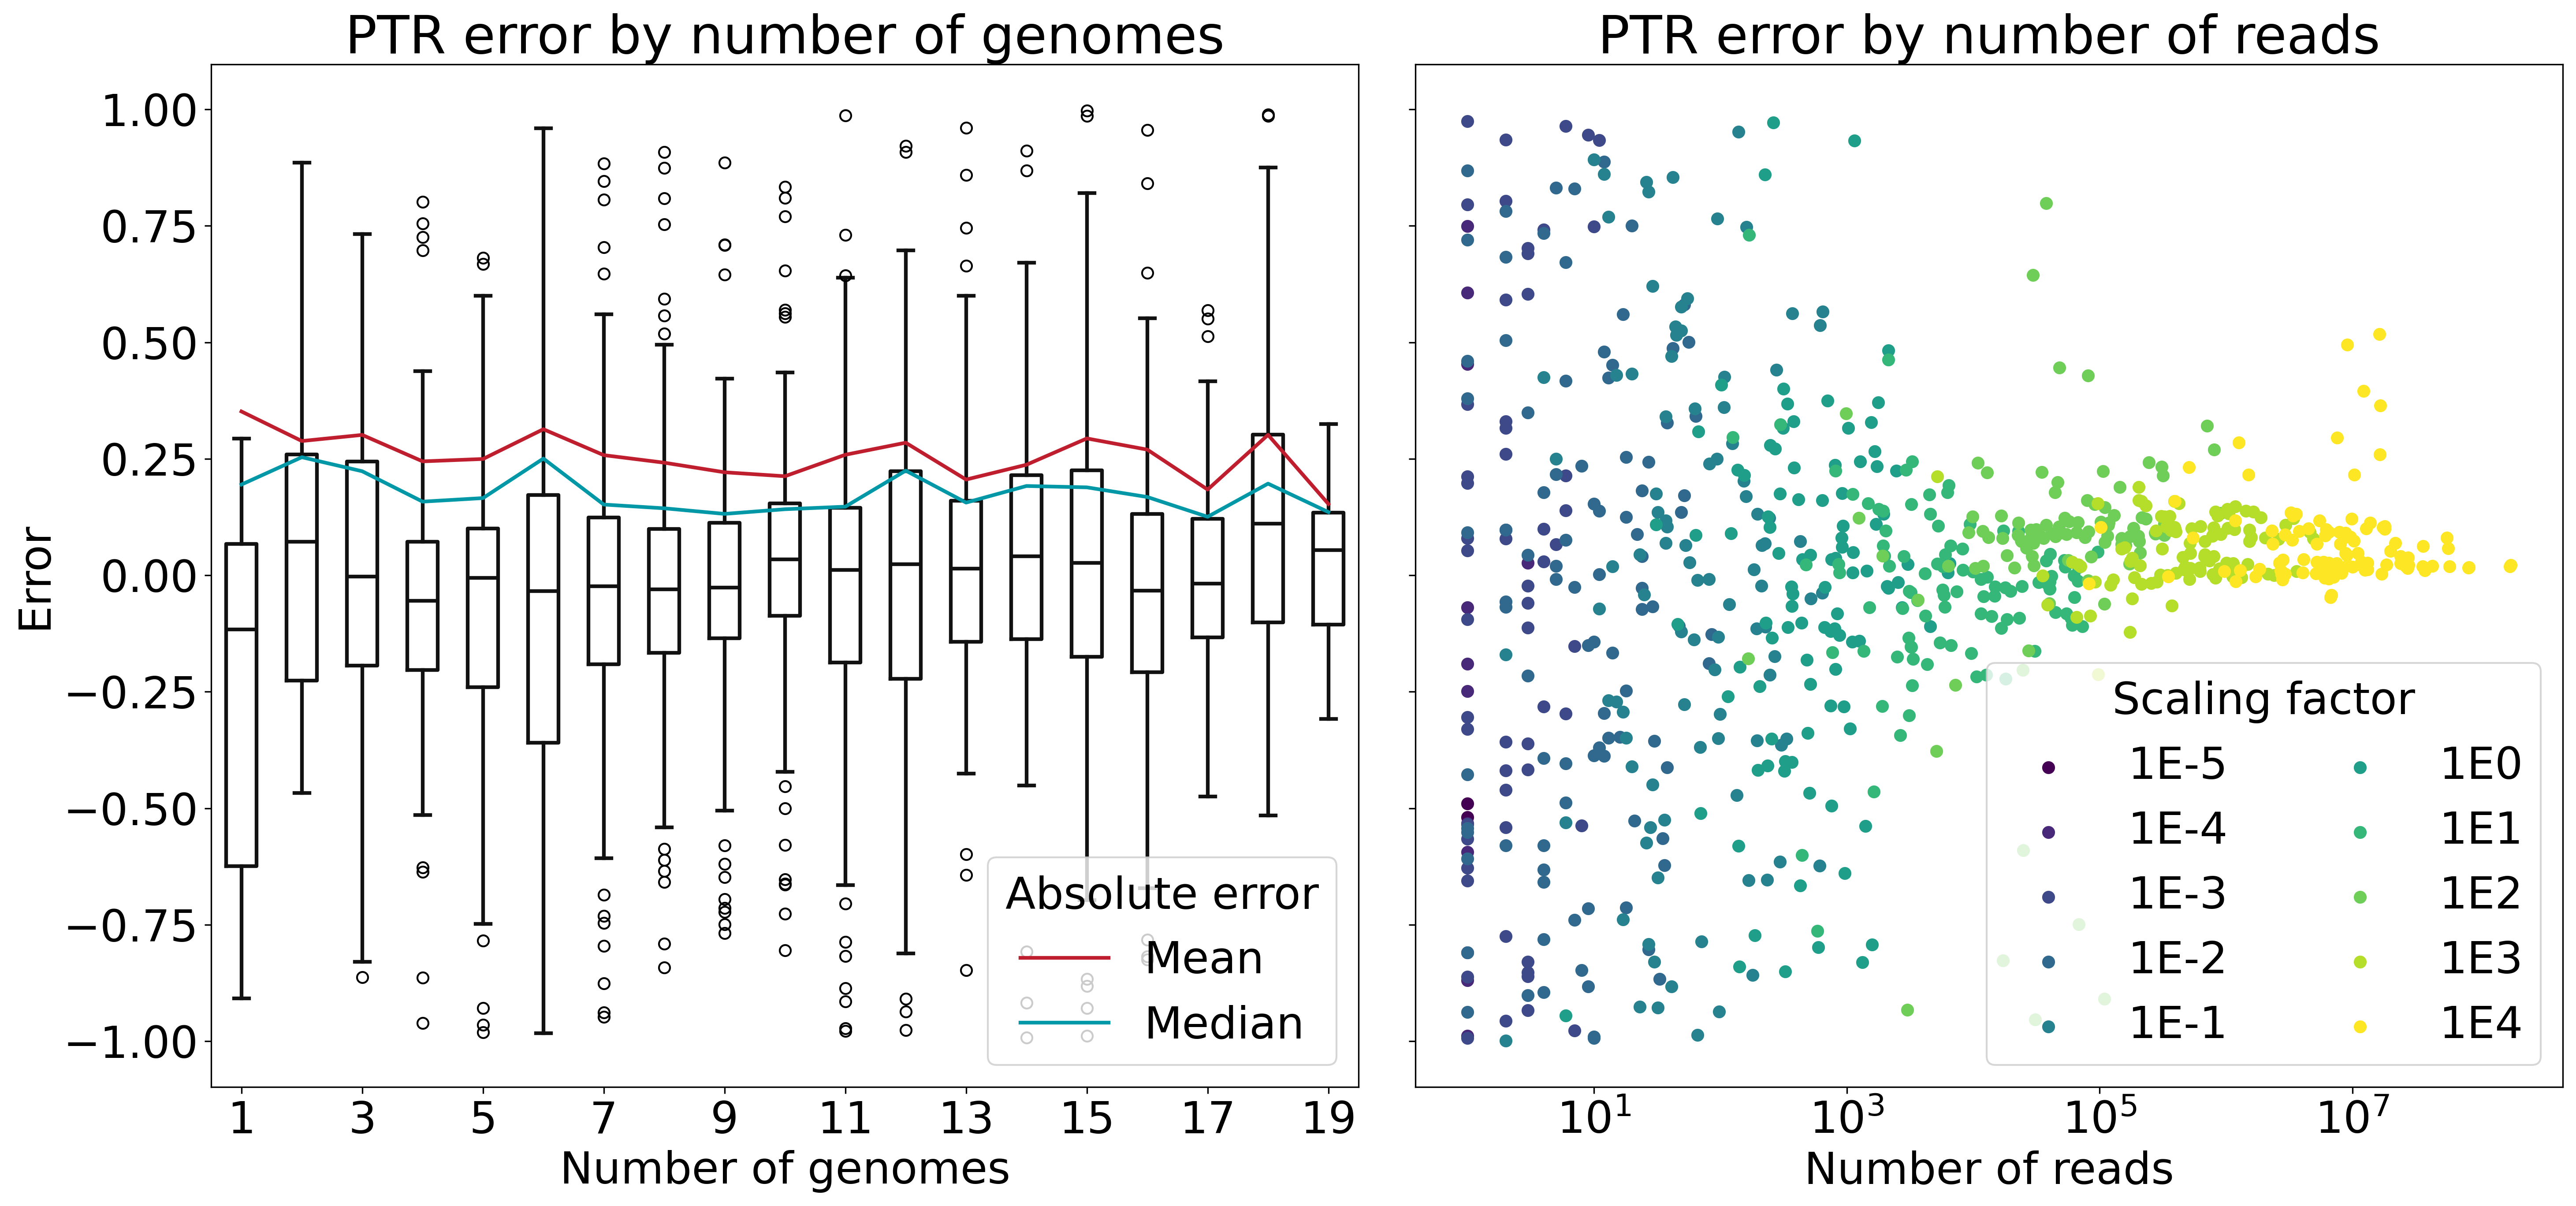

In [4]:
# Combine figures 2 and 3 into a single plot:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

# Fig 1
ax1 = scaling_matrix1.boxplot(by="n_genomes", column="ptr_score", ax=ax1, grid=False)

# Make boxplots thicker and #111111
for i, artist in enumerate(ax1.get_children()):
    if isinstance(artist, plt.Line2D):
        artist.set_color("#111111")
        artist.set_linewidth(2)

# Draw error on same figure with different y axis
g = scaling_matrix1[["n_genomes", "ptr_score"]].abs().groupby("n_genomes")["ptr_score"]
ax1.plot(np.arange(1, 20), g.mean(), c="#BE1E2D", lw=2, label="Mean")
ax1.plot(np.arange(1, 20), g.median(), c="#0097A7", lw=2, label="Median")
ax1.set_ylabel("Error")
ax1.set_xlabel("Number of genomes")
ax1.set_title("PTR error by number of genomes")
ax1.set_xticks(np.arange(1, 20, 2), np.arange(1, 20, 2))
ax1.legend(title="Absolute error", loc="lower right")

# Fig 3
scaling_factors = scaling_matrix2["scaling"].unique()
colors = cm.get_cmap("viridis", len(scaling_factors))

for i, scaling_factor in enumerate(scaling_factors):
    f = scaling_matrix2[scaling_matrix2["scaling"] == scaling_factor]
    ax2.scatter(f["n_reads"], f["ptr_score"], label=f"1E{scaling_factor}", c=colors(i))

ax2.set_xscale("log")
ax2.set_xlabel("Number of reads")
# ax2.set_ylabel("Error")
ax2.set_title("PTR error by number of reads")
ax2.legend(title="Scaling factor", ncol=2, loc="lower right")#, fontsize=16, title_fontsize=16)

fig.suptitle("")
plt.tight_layout()
plt.show()

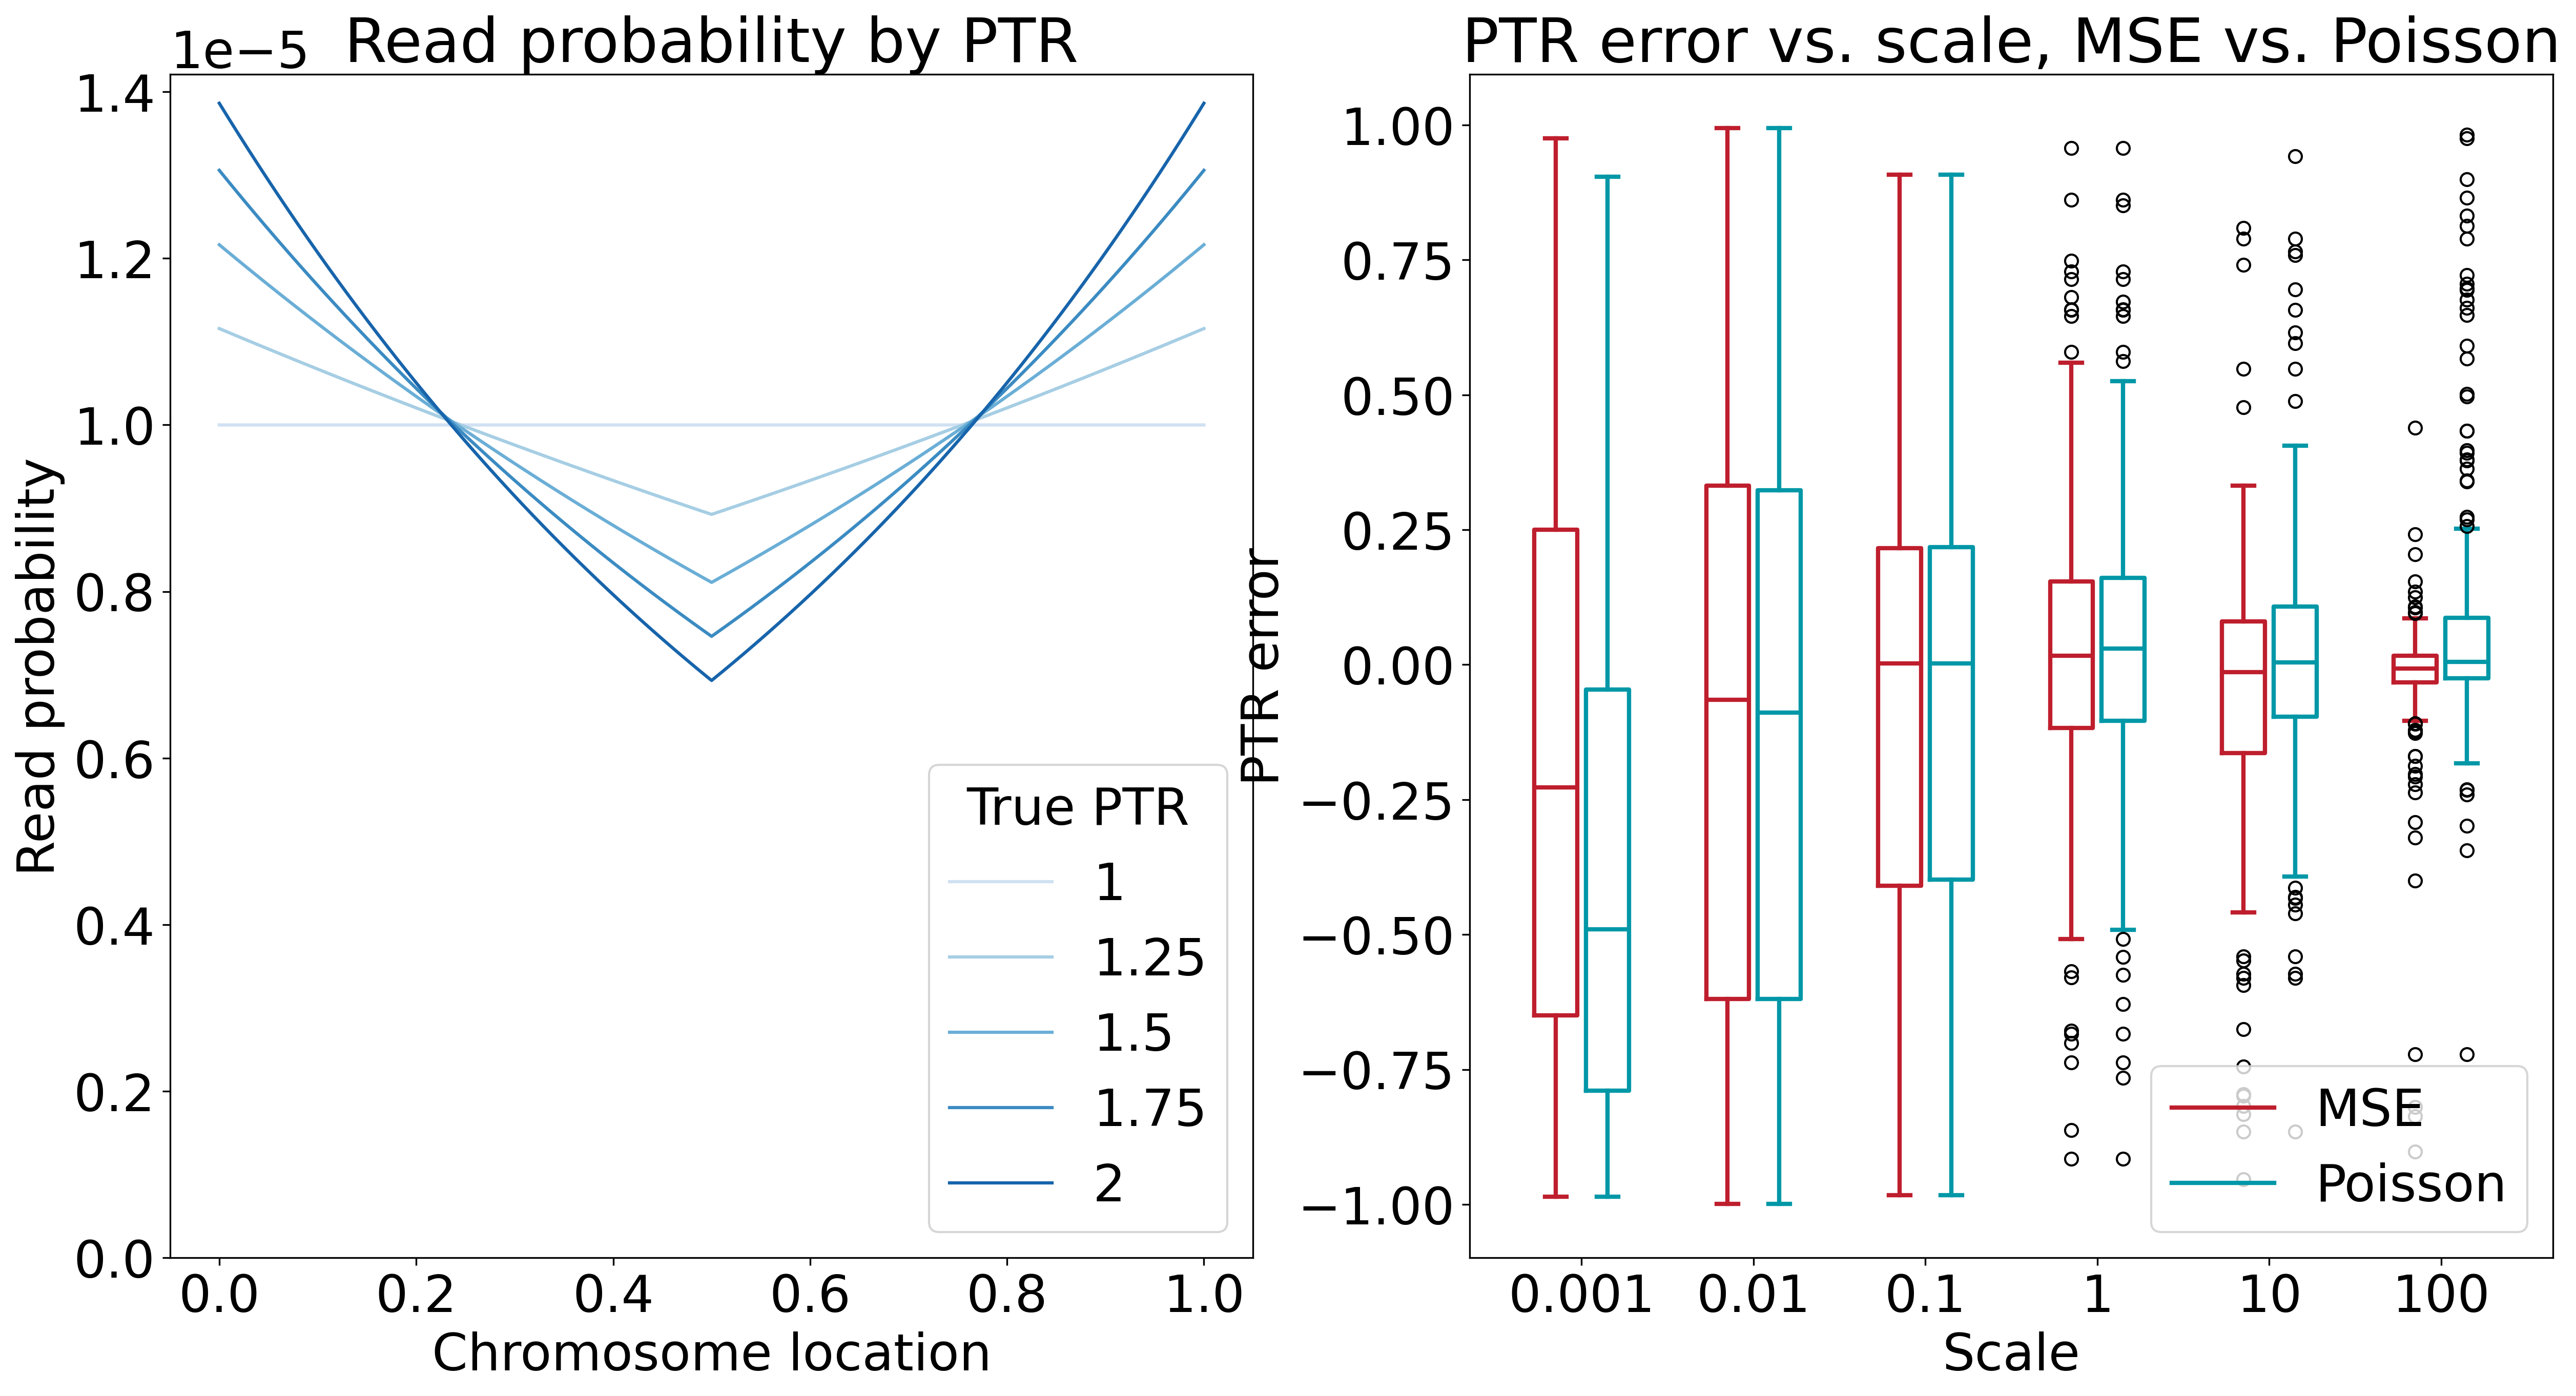

In [7]:
# Combine figure 4 and 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Figure 1
x = np.linspace(0, 1, 100000)
dists = oor_distance(x)
colors = plt.cm.Blues(np.linspace(0.2, 0.8, 5))

# Shades of blue
for ptr, color in zip([1, 1.25, 1.5, 1.75, 2], colors):
    y = _exact_coverage_curve(log_ptr=np.log(ptr), distances=dists)
    y /= np.sum(y)
    ax1.plot(x, y[0,:], label=ptr, color=color)
ax1.set_ylim(0, ax1.get_ylim()[1])
ax1.set_xlabel("Chromosome location")
ax1.set_ylabel("Read probability")
ax1.set_title("Read probability by PTR")
ax1.legend(title="True PTR", loc="lower right")

# Figure 4
losses = poisson_gaussian["loss_fn"].unique()
for_boxplot_mse = poisson_gaussian[poisson_gaussian["loss_fn"] == losses[0]]
for_boxplot_poisson = poisson_gaussian[poisson_gaussian["loss_fn"] == losses[1]]
x1 = [for_boxplot_mse[for_boxplot_mse["scale"] == 10**i]["ptr_score"] for i in range(-3, 3)]
x2 = [for_boxplot_poisson[for_boxplot_poisson["scale"] == 10**i]["ptr_score"] for i in range(-3, 3)]

# Plot
bp1 = ax2.boxplot(x1, positions=[1, 2, 3, 4, 5, 6], widths=0.25)
bp2 = ax2.boxplot(x2, positions=[1.3, 2.3, 3.3, 4.3, 5.3, 6.3], widths=0.25)
ax2.set_xticks([1.15, 2.15, 3.15, 4.15, 5.15, 6.15], [10**i for i in range(-3, 3)])
ax2.set_xlabel("Scale")
ax2.set_ylabel("PTR error")
ax2.set_title("PTR error vs. scale, MSE vs. Poisson")

# Change colors for medians
for b, c in zip([bp1, bp2], ["#BE1E2D", "#0097A7"]):
    for prop in ["medians", "boxes", "whiskers", "caps", "fliers"]:
        for x in b[prop]:
            x.set(color=c, linewidth=2)

ax2.legend([bp1["boxes"][0], bp2["boxes"][0]], ["MSE", "Poisson"], loc="lower right")

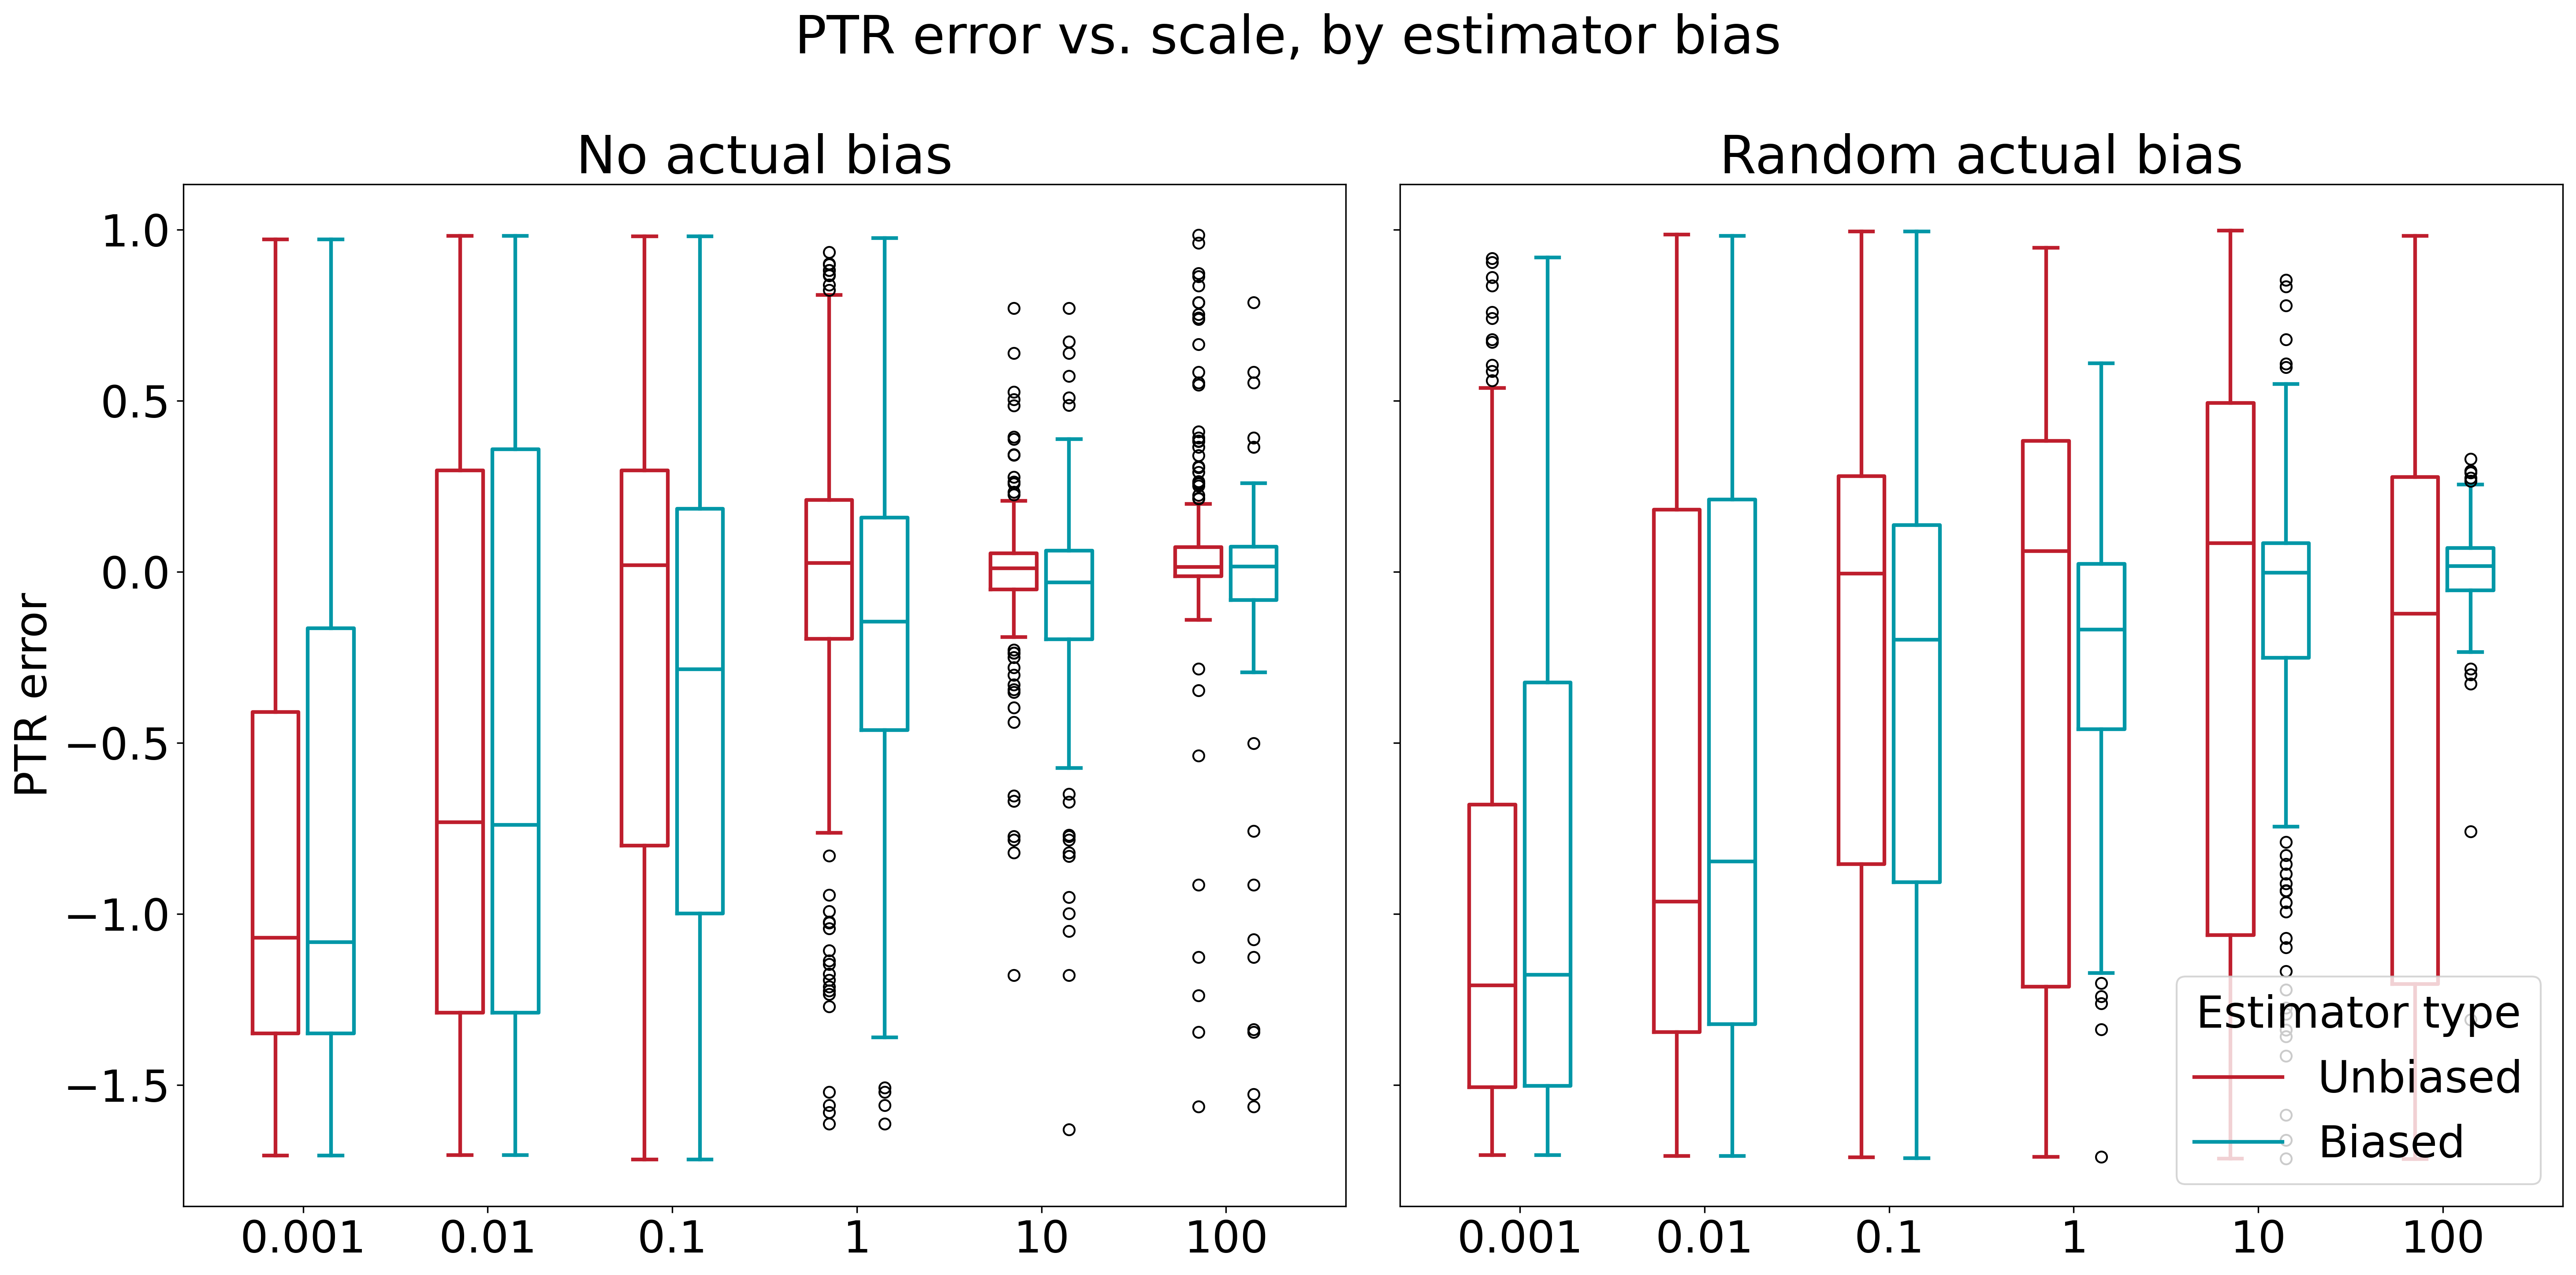

In [6]:
# Figures 5 and 6

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

# Make data
for ax, simulation_bias in zip((ax1, ax2), [False, True]):
    results_filtered = amplicon_bias[amplicon_bias["simulation_bias"] == simulation_bias]
    for_boxplot_unbiased = results_filtered[results_filtered["model_bias"] == False]
    for_boxplot_bias = results_filtered[results_filtered["model_bias"] == True]
    x1 = [for_boxplot_unbiased[for_boxplot_unbiased["scale"] == 10**i]["ptr_score"] for i in range(-3, 3)]
    x2 = [for_boxplot_bias[for_boxplot_bias["scale"] == 10**i]["ptr_score"] for i in range(-3, 3)]

    # Plot
    bp1 = ax.boxplot(x1, positions=[1, 2, 3, 4, 5, 6], widths=0.25)
    bp2 = ax.boxplot(x2, positions=[1.3, 2.3, 3.3, 4.3, 5.3, 6.3], widths=0.25)
    ax.set_xticks([1.15, 2.15, 3.15, 4.15, 5.15, 6.15], [10**i for i in range(-3, 3)])

    # Change colors for medians
    for b, c in zip([bp1, bp2], ["#BE1E2D", "#0097A7"]):
        for prop in ["medians", "boxes", "whiskers", "caps", "fliers"]:
            for x in b[prop]:
                x.set(color=c, linewidth=2)

# Only 1 ax:
ax1.set_ylabel("PTR error")
ax2.legend([bp1["boxes"][0], bp2["boxes"][0]], ["Unbiased", "Biased"], loc="lower right", title="Estimator type")

# Titles:
ax1.set_title("No actual bias")
ax2.set_title("Random actual bias")

fig.suptitle("PTR error vs. scale, by estimator bias")
plt.tight_layout()
plt.show()